In [30]:
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
df = pd.read_csv("save_data_test.csv")

In [43]:
L = df.columns.to_list()
time_cols = L[0:55:4]
sb_cols = L[1:55:4]
pb_cols = L[2:55:4]
wb_cols = L[3:55:4]

In [ ]:
df[pb_cols] = df[pb_cols].to_numpy() / 1e10
df[pb_cols].plot()


<Axes: >

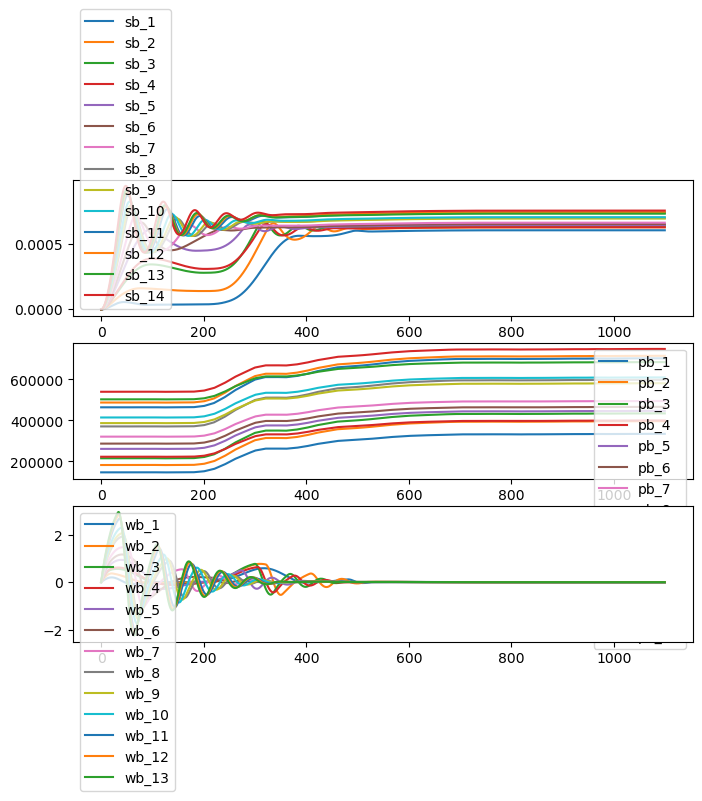

In [44]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6))
df[sb_cols].plot(ax=axs[0])
df[pb_cols].plot(ax=axs[1])
df[wb_cols].plot(ax=axs[2])